# Quick tutorial on the Gaussian process regression module from btjenesten

<b>Developed by</b> Elias Anderssen Dalan <a href="mailto:ceadyy@gmail.com">✉️</a>, supported by Centre for Computing in Science Education and Hylleraas Centre for Quantum Molecular Sciences.

### Things you might need to know before tackling this notebook:
<ul>
  <li><a href="https://audunsh.github.io/openworld/polynomial_regression/">Notebook on polynomial regression </a></li>
  <li><a href="https://audunsh.github.io/openworld/Covariance/">Notebook on covariance</a></li>
  <li><a href="https://audunsh.github.io/openworld/Kernels/">Notebook on kernels</a></li>
  <li><a href="https://audunsh.github.io/openworld/GPR_intro/">Notebook on Gaussian process regression</a></li>
</ul>

This notebook aims to give a quick and consise introduction to the different features of the Gaussian process regression module. We will take a look at the example function $f(x, y) = \frac{1}{(1 + x^2 + y^2)}$ and try to maximize it iteratively, by using the regressors own aquisition function. Lets first take a look at our model function.

In [1]:
import matplotlib.pyplot as plt
from btjenesten import gpr
from btjenesten import kernels
import numpy as np

In [2]:
def f(x, y):
    return (1 + x**2 + y**2)**(-1)

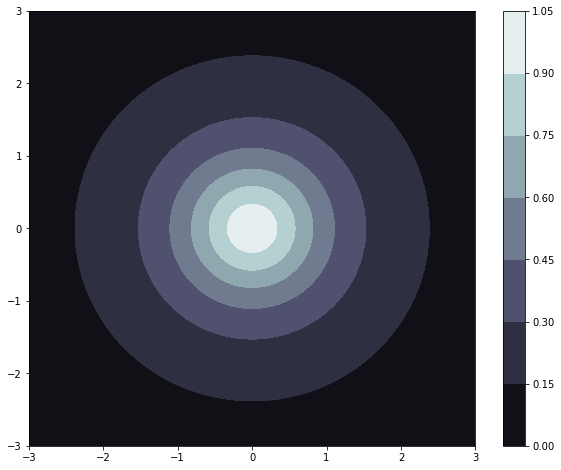

In [3]:
xy = np.linspace(-3, 3, 100)

f(*np.meshgrid(xy, xy))

plt.figure(figsize=(10, 8))
plt.contourf(xy, xy, f(*np.meshgrid(xy, xy)), cmap="bone")
plt.colorbar()
plt.show()

# Setting up a regressor

We can observe that the function only has one maxima, and that is $f(0,0) = 1$. The first thing we will look at is how to set up a regressor. Our regressor needs to things:
<ul>
    <li> A set of parameters, often called training features. In our case this is some set of pairs of $(x,y)$.
    <li> A set of corresponding outputs, often called training labels. In your case this will be the function values $f(x,y)$ evaluated at the previously mentioned pairs of $(x,y)$.
</ul>

To show the flexibility of Gaussian process regression we will create our training data randomly.

In [4]:
N_pairs = 5

x_y_pairs = np.random.uniform(-3, 3, (N_pairs, 2)) #Now a set of N_pairs pairs
f_xy = f(x_y_pairs[:,0], x_y_pairs[:,1])

regressor = gpr.Regressor(x_y_pairs, f_xy)

Now lets take a look at our function and the randomly generated points that we will train our regressor on:

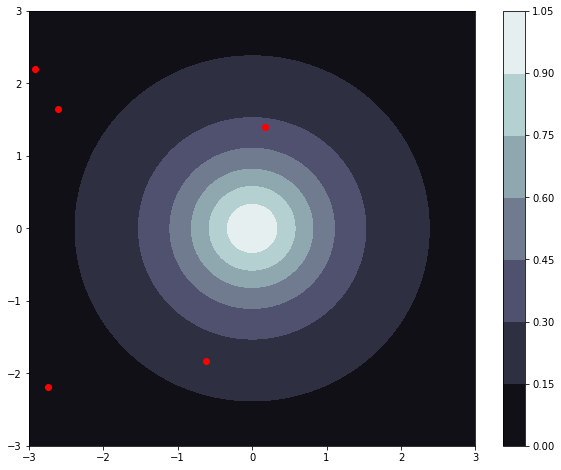

In [5]:
plt.figure(figsize=(10, 8))
plt.scatter(x_y_pairs[:,0], x_y_pairs[:,1], zorder=10, color="red")
plt.contourf(xy, xy, f(*np.meshgrid(xy, xy)), cmap="bone")
plt.colorbar()
plt.show()

# Predicting an unknown value

We know that our function has only one maxima, at $(0,0)$, with the corresponding value 1. Lets try to evaluate it there to see how good the current regressor is!

In [6]:
zero_zero = [0,0]
zero_zero = np.array(zero_zero)

#If you want to use the predict-method to only evaluate one point you have to reshape the input data as so:
zero_zero = zero_zero.reshape(1, -1)

predicted_f = regressor.predict(zero_zero)

print(f"True value at (0,0) = 1, predicted value = {predicted_f[0]}")

True value at (0,0) = 1, predicted value = 0.052142668694110696


# Updating our regressor
The predicted answer may be great or may be terrible, based on how lucky we are with the random training data that was created earlier in this notebook. One way we can obtain a better approximation is by expanding the training data. Lets add two more sets of $(x, y)$. We can tinker with these points to see how it affects our regressor, try changing them! What do you think will happen if we added $(0,0)$ to the training set?

In [7]:
p1 = [0.5, 0.5]
p1 = np.array(p1)

p2 = [-0.3, -0.3]
p2 = np.array(p2)

f_p1 = f(p1[0], p1[1])
f_p1 = np.array([f_p1])

f_p2 = f(p2[0], p2[1])
f_p2 = np.array([f_p2])

regressor.update(p1, f_p1, tol=1e-12)
regressor.update(p2, f_p2, tol=1e-12)

predicted_f = regressor.predict(zero_zero)

print(f"True value at (0,0) = 1, predicted value = {predicted_f[0]}")

True value at (0,0) = 1, predicted value = 0.8688962543728831


You might have notices an additional parameter given to the update-funciton, called ```tol```. If two sets of parameters in our training data are too close to eachother we might encounter what is called a *Singular matrix*, that is, a matrix whose determinant is zero which means it cannot be inverted. If this happends, our regressor will stop working, which is why a tolerance has to be set. If the tolerance is not high enough, you may not be able to obtain a desired precision in your training data, but if it is too low the regressor might crash. When trying to model a new system til parameter will probably need some tinkering, but a general rule of thumb is that $10^{-8}$ is a good value.

# Using our regressor to maximise/minimize our function

If you are using the regressor to model some kind of process that can either be maximized or minimized, the aquisition function is what you need. The aquisition function takes the model function that the gpr has predicted, and tries to optimize it. If you run ```regressor.aquisition```the regressor tries to guess where you should measure next in order to maximize or minimize your function, depending on your choice. The aquisition function looks like this:

\begin{equation}
UCB(\mathbf{x}; \delta, \lambda) = GPR(\mathbf{x}) + [(1 - \sigma(\mathbf{x}))^2 \cdot \delta + \sigma(\mathbf{x})] \cdot \lambda,
\end{equation}

where $\sigma(\mathbf{x})$ is the standard deviation, and $\delta$ and $\lambda$ are variables that can be adjusted to allow for more exploration. $\delta$ governs exploration around training points where the standard deviation is low, while $\lambda$ governs exploration of the whole function. Think:  Now let us see if we can to to get our model to converge at $(0,0)$. 

In [8]:
n_updates = 10

for i in range(n_updates):
    p = regressor.aquisition(minimize_prediction=False, l=1, delta = 0.5)
    
    f_p = f(p[0], p[1])
    f_p = np.array([f_p])
    
    regressor.update(p, f_p, tol=1e-8)
    
    predicted_f = regressor.predict(zero_zero)
    print(f"True value at (0,0) = 1, predicted value = {predicted_f[0]}")

True value at (0,0) = 1, predicted value = 0.9364740014725015
True value at (0,0) = 1, predicted value = 0.9996492598515815
True value at (0,0) = 1, predicted value = 0.999823442203569
True value at (0,0) = 1, predicted value = 1.0000093361530311
True value at (0,0) = 1, predicted value = 0.9999985445656705
True value at (0,0) = 1, predicted value = 1.0000000958345128
True value at (0,0) = 1, predicted value = 0.9999999998780275
True value at (0,0) = 1, predicted value = 0.9999999999639124
True value at (0,0) = 1, predicted value = 1.0000000001100622
True value at (0,0) = 1, predicted value = 1.0000000001522567


You might notice the parameter ```tol``` passed into the update function. A problem we might encounter when updating our training set is duplicates inside of our training data. If our training data has duplicates, we encounter something called a $\textit{singular matrix}$. A singular matrix cannot be inverted, which the regressor must do when trying to predict a value for some input $\mathbf{x}$. The ```tol``` parameter is here to prevent this, and might need to be fine-tuned to optimalize our model. If ```tol```is to low, we might encounter a singular matrix, but if it is too high our model might converge prematurely.

# How well does our model function perform?

The last function that our module has is a function to calculate some type of score for our function, more specifically the average and maximum error from the true function. Lets now try to generate 10000 random test samples and calculate the average and maximum deviation between our model and true function.

In [9]:
N_test = 10000

x_y_test = np.random.uniform(-1, 1, (N_test, 2))
f_x_y_test = f(x_y_test[:,0], x_y_test[:,1])

average_error, maximum_error = regressor.score(x_y_test, f_x_y_test)

print(f"The average error of the test set was: {average_error}, while the maximum error was: {maximum_error}")

The average error of the test set was: 0.045343406576550775, while the maximum error was: 0.22710267339456108
